In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from skimage import io, transform
from skimage.transform import resize
import zipfile

import torchvision


[Project Desc.](https://people.cs.pitt.edu/~kovashka/cs1678_sp21/hw2.html )

In [ ]:
def fetch_data():
  '''
    download data to workspace
  '''
  !wget https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip
  !mkdir data/
  with zipfile.ZipFile("cifar10.zip","r") as z:
    z.extractall("/data/")
  %rm cifar10.zip
  %cd /data/
  
def get_labels(root_dir):
  '''
    retrieve labels from root directory and load into a dictionary with corresponding integers for each image type.

    input: root_dir -- filepath of dataset
    output: dicionary with labels and their corresponding integers
  '''
  labels = {}
  for i, label in enumerate(os.listdir(root_dir)):
    labels[i] = label
  return labels

def organize_data(root_dir):
  '''
    format data in root directory into a a single dictionary for perfomance enhancments.

    input: root_dir -- filepath of dataset
    output: dicionary with all images and labels(integers) in a given directory..
  '''
  imgs  =[]
  labels={}
  for i, label in enumerate(os.listdir(root_dir)):
    labels[i] = label
    for img_path in os.listdir(os.path.join(root_dir, label)):
      img = mpimg.imread(os.path.join(root_dir, label, img_path))
      # resize(img, (224, 244))
      imgs.append((i, img))

  return imgs

In [ ]:
class CifarDataset(torch.utils.data.Dataset):

  '''
    Custom Data Loader
  '''

  def __init__(self, root_dir, transform=None):
    '''
      Initializes a dataset containing images and labels.
    '''
    super().__init__()
    fetch_data()
    self.root_dir = root_dir
    self.labels = get_labels(root_dir)
    self.images = organize_data(root_dir)
    self.transform = transform

  def __len__(self):
    '''
      Returns the size of the dataset.
    '''
    return len(self.images)

  def __getitem__(self, X):
    '''
      Returns the index-th data item of the dataset.
    '''
    if torch.is_tensor(X):
            X = X.tolist()

    image = self.images[X][1]
    label = self.images[X][0]

    if self.transform:
      image = self.transform(image)

    sample = {'image':image, 'label':label}
      
    return sample

In [ ]:
# preproscessing transformations

class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        sample = transform.resize(sample, (self.output_size, self.output_size))

        return sample

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        sample = torch.Tensor(np.asarray(sample))
        return sample

class ToHCHW(object):
    """Swap input dimensions from HWC to CHW (Batch, Channel, Height, Width)"""
    def __call__(self, sample):
        sample = torch.Tensor(np.asarray(sample))
        sample = sample.permute(2, 0, 1)
        return sample

In [ ]:
train_dataset = CifarDataset('/data/cifar10_train/', transform=torchvision.transforms.Compose([ToTensor()]))
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=20,
                                               shuffle=True)

test_dataset = CifarDataset('/data/cifar10_test/', transform=torchvision.transforms.Compose([ToTensor()]))
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=20,
                                               shuffle=True)

--2021-03-19 00:19:07--  https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip
Resolving people.cs.pitt.edu (people.cs.pitt.edu)... 136.142.35.172
Connecting to people.cs.pitt.edu (people.cs.pitt.edu)|136.142.35.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147491716 (141M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 140.66M   285MB/s    in 0.5s    

2021-03-19 00:19:08 (285 MB/s) - ‘cifar10.zip’ saved [147491716/147491716]

mkdir: cannot create directory ‘data/’: File exists
/data
--2021-03-19 00:19:44--  https://people.cs.pitt.edu/~mzhang/cs1699/cifar10.zip
Resolving people.cs.pitt.edu (people.cs.pitt.edu)... 136.142.35.172
Connecting to people.cs.pitt.edu (people.cs.pitt.edu)|136.142.35.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147491716 (141M) [application/zip]
Saving to: ‘cifar10.zip’

cifar10.zip         100%[===================>] 140.66M   252MB/s    in 0.6s    

20

In [ ]:
class MultiLayerPerceptronModel(nn.Module):
  '''
    3-layer MLP model
  '''
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer1 = nn.Linear(input_size, hidden_size)
    self.layer2 = nn.Dropout(p=0.1)
    self.layer3 = nn.ReLU()
    self.layer4 = nn.Dropout(p=0.25)
    self.layer5 = nn.Linear(hidden_size, num_classes)
    
  def forward(self, x):
    # print(x.shape)
    out = self.layer1(x.reshape(-1, 32*32*3))
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    return out

In [ ]:
# hyperparams
input_size = 32*32*3
hidden_size = 800
learning_rate = 0.0005
max_epochs = 10
num_classes = 10

In [ ]:
from tqdm import tqdm_notebook
import torch

def training(model, dataloader, input_size = input_size, hidden_size=hidden_size, learning_rate=learning_rate, max_epochs=max_epochs):
  '''
    Performs training on the model
  '''

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate) # weight_decay = 0.0001er
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(dataloader))

  device = 'cuda'
  model = model.to(device)

  total_epochs = tqdm_notebook(range(max_epochs))
  loss_per_sample = []

  model.train() 
  # Training
  for epoch in total_epochs:
      for i, data in enumerate(dataloader):
          images, labels = data['image'], data['label']

          # Transfer to GPU
          images = images.to(device)
          labels = labels.to(device)

          # Forward pass
          outputs = model(images) 
          loss = criterion(outputs, labels)
          loss_per_sample.append(float(loss))

          # Backward and optimize
          loss.backward()
          optimizer.step()
          scheduler.step() # scheduler.step(epoch + i / len)
          optimizer.zero_grad()

  return loss_per_sample

In [ ]:
def evaluation(model, dataloader):
  '''
    loads the trained model and evaluates its performance on train/test set.

    input: train or test set.

  '''
  batch_to_view = []    # for visual.

  criterion = nn.CrossEntropyLoss()

  device = 'cuda'
  model = model.to(device)

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    for i, data in enumerate(tqdm_notebook(dataloader)):
      images = data['image']
      labels = data['label']
        
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # note: just shows loss from last iteration. Not running loss...
      loss = criterion(outputs, labels)

      if i < 1:
        batch_to_view.append(data)


    print('loss: {:.2f}'.format(float(loss)))
    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

  return batch_to_view

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



loss: 1.65
Accuracy of the network on the 10000 test images: 43.27 %


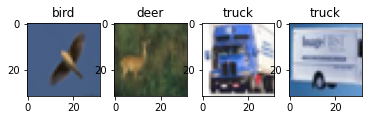

In [ ]:
model = MultiLayerPerceptronModel(input_size, hidden_size, num_classes)
loss_per_sample = training(model, train_dataloader)
batch_to_view = evaluation(model, test_dataloader)
imshow(batch_to_view)

In [ ]:
# loss curve

figure = plt.scatter(list(range(0, len(loss_per_sample))), loss_per_sample)
plt.xlabel('Training iteration')
plt.ylabel('Error (abs) ')
plt.show()

In [ ]:
def imshow(samples, transform=None):
    '''
      Shows images i=with predicted labels.
    '''
    f, figure = plt.subplots(1,4)

    for i in range(4):
      if transform:
        figure[i].imshow(samples[0]['image'][i].permute(1, 2, 0))   #convert back to HWC
      else:
        figure[i].imshow(samples[0]['image'][i])

      figure[i].set_title(transformed_test_dataset.labels[int(samples[0]['label'][i])])

In [ ]:
# Evaluating Different Hyperparamaters

# I experimented with the batch size, hidden size, dropout, learning rate, lr_schedueler and optimizer type.
# I did my all my tests on 15 epochs and wrote down the first output recieved. 
# I found that a combination of AdamW and CosineAnnealingLR with a batch size arround 20 and hidden size of 450 yielded the best results. 
# If I were to do further testing I would try out more Optimizers such as ASGD, AdaGrad and AdaMax.

# Test Results

# batch size    - 10      | 15      | 20
#   * accuracy  - 51.41%  | 51.96%  | 55.70%
#   * loss      - 1.68    | 1.03    | 1.70

# hidden size   - 100     | 450     | 800
#   * accuracy  - 45.47%  | 51.96%  | 52.21% 
#   * loss      - 1.57    | 0.97    | 2.28 

# dropout       - 0.25    | 0.5     | .8
#   * accuracy  - 54.97%  | 46.94%  | 38.78%
#   * loss      - 1.01    | 1.70    | 2.01

# learning rate - 0.001   | 0.0005  | 0.0001
#   * accuracy  - 51.44%  | 51.854  | 42.12
#   * loss      - 1.78    | 1.06    | 2.13

# lr_schedueler - CosineAnnealingLR | CosineAnnealingWarmRestarts | StepLR
#   * accuracy  - 54.97%            | 40.74%                      | 39.79%
#   * loss      - 1.01              | 0.99                        | 1.04

# optimizer     - Adam     | AdamW  | SGD
#   * accuracy  - 55.05%   | 51.07% | 35.11%
#   * loss      - 1.30     | 1.19   | 1.94

ImageNet pre-trained MobileNetV2 model finetunes on Cifar10 Dataset.


Load a MobileNetV2 model with pretrained weights using torchvision library, and replace the final classification layer using a new randomly initialized fully-connected layer and finetune on the Cifar10 Dataset. 

Two flavors of transfer learning

(1) freezing all the MobileNetV2 layers (feature extraction) and only train the final classification layer; 


(2) finetuning all MobileNetV2 layers together with the final classification layer. 

("finetuning" = model is further trained with small learning rate, thus the weights do not change significantly but it will hopefully lead to improved performance.) 

Report (in a text snippet in your notebook) the performance of the two models on train/test set.

In [ ]:
transformed_train_dataset = CifarDataset('/data/cifar10_train/', transform=torchvision.transforms.Compose([Rescale(224),
                                                                                               ToHCHW()]))
transformed_train_dataloader = torch.utils.data.DataLoader(transformed_train_dataset,
                                               batch_size=15,
                                               shuffle=True)

transformed_test_dataset = CifarDataset('/data/cifar10_test/', transform=torchvision.transforms.Compose([Rescale(224),
                                                                                               ToTensor(),
                                                                                               ToHCHW()]))
transformed_test_dataloader = torch.utils.data.DataLoader(transformed_test_dataset,
                                               batch_size=15,
                                               shuffle=True)

NameError: ignored

In [ ]:
# hyperparams
input_size = 224*224*3
hidden_size = 350
learning_rate = 0.0005
max_epochs = 1
num_classes = 10
feature_extract = False

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  '''
    Deactive layers for feature extraction 
  '''
  if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

mobilenet_model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2', pretrained=True)

set_parameter_requires_grad(mobilenet_model, feature_extract)

# edit final classification layer
num_ftrs = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] =  nn.Linear(num_ftrs, num_classes)
mobilenet_model.eval()


# gather parameters to optimize

params_to_update = mobilenet_model.parameters()
if feature_extract:                                         #   feature extraction --> only update final layer
    params_to_update = []
    for name,param in mobilenet_model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:                                                       #   otherwise finetune
    for name,param in mobilenet_model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

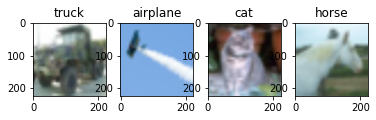

In [ ]:
training(mobilenet_model, transformed_train_dataloader, max_epochs=1)
batch_to_view = evaluation(mobilenet_model, transformed_test_dataloader)
imshow(batch_to_view, transform=True)   

In [ ]:
#                     Accuracy    Loss
# feature extraction:  76.69 %    0.91
# fine tuning:         92.81 %    0.22